# Imports

In [19]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, RFE, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay


from joblib import Memory, dump, load
location = './cachedir'
memory = Memory(location)

# Content

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

# EDA

In [20]:
df = pd.read_csv('creditcard.csv')
X = df[df.columns[0:-1]]
y = df['Class']
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [21]:
X.shape

(284807, 30)

array([[<Axes: title={'center': 'Time'}>, <Axes: title={'center': 'V1'}>,
        <Axes: title={'center': 'V2'}>, <Axes: title={'center': 'V3'}>,
        <Axes: title={'center': 'V4'}>, <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>, <Axes: title={'center': 'V9'}>,
        <Axes: title={'center': 'V10'}>, <Axes: title={'center': 'V11'}>],
       [<Axes: title={'center': 'V12'}>, <Axes: title={'center': 'V13'}>,
        <Axes: title={'center': 'V14'}>, <Axes: title={'center': 'V15'}>,
        <Axes: title={'center': 'V16'}>, <Axes: title={'center': 'V17'}>],
       [<Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>, <Axes: title={'center': 'V21'}>,
        <Axes: title={'center': 'V22'}>, <Axes: title={'center': 'V23'}>],
       [<Axes: title={'center': 'V24'}>, <Axes: title={'center': 'V25'}>,
        <Axes: title={'center': 'V26'}>, <

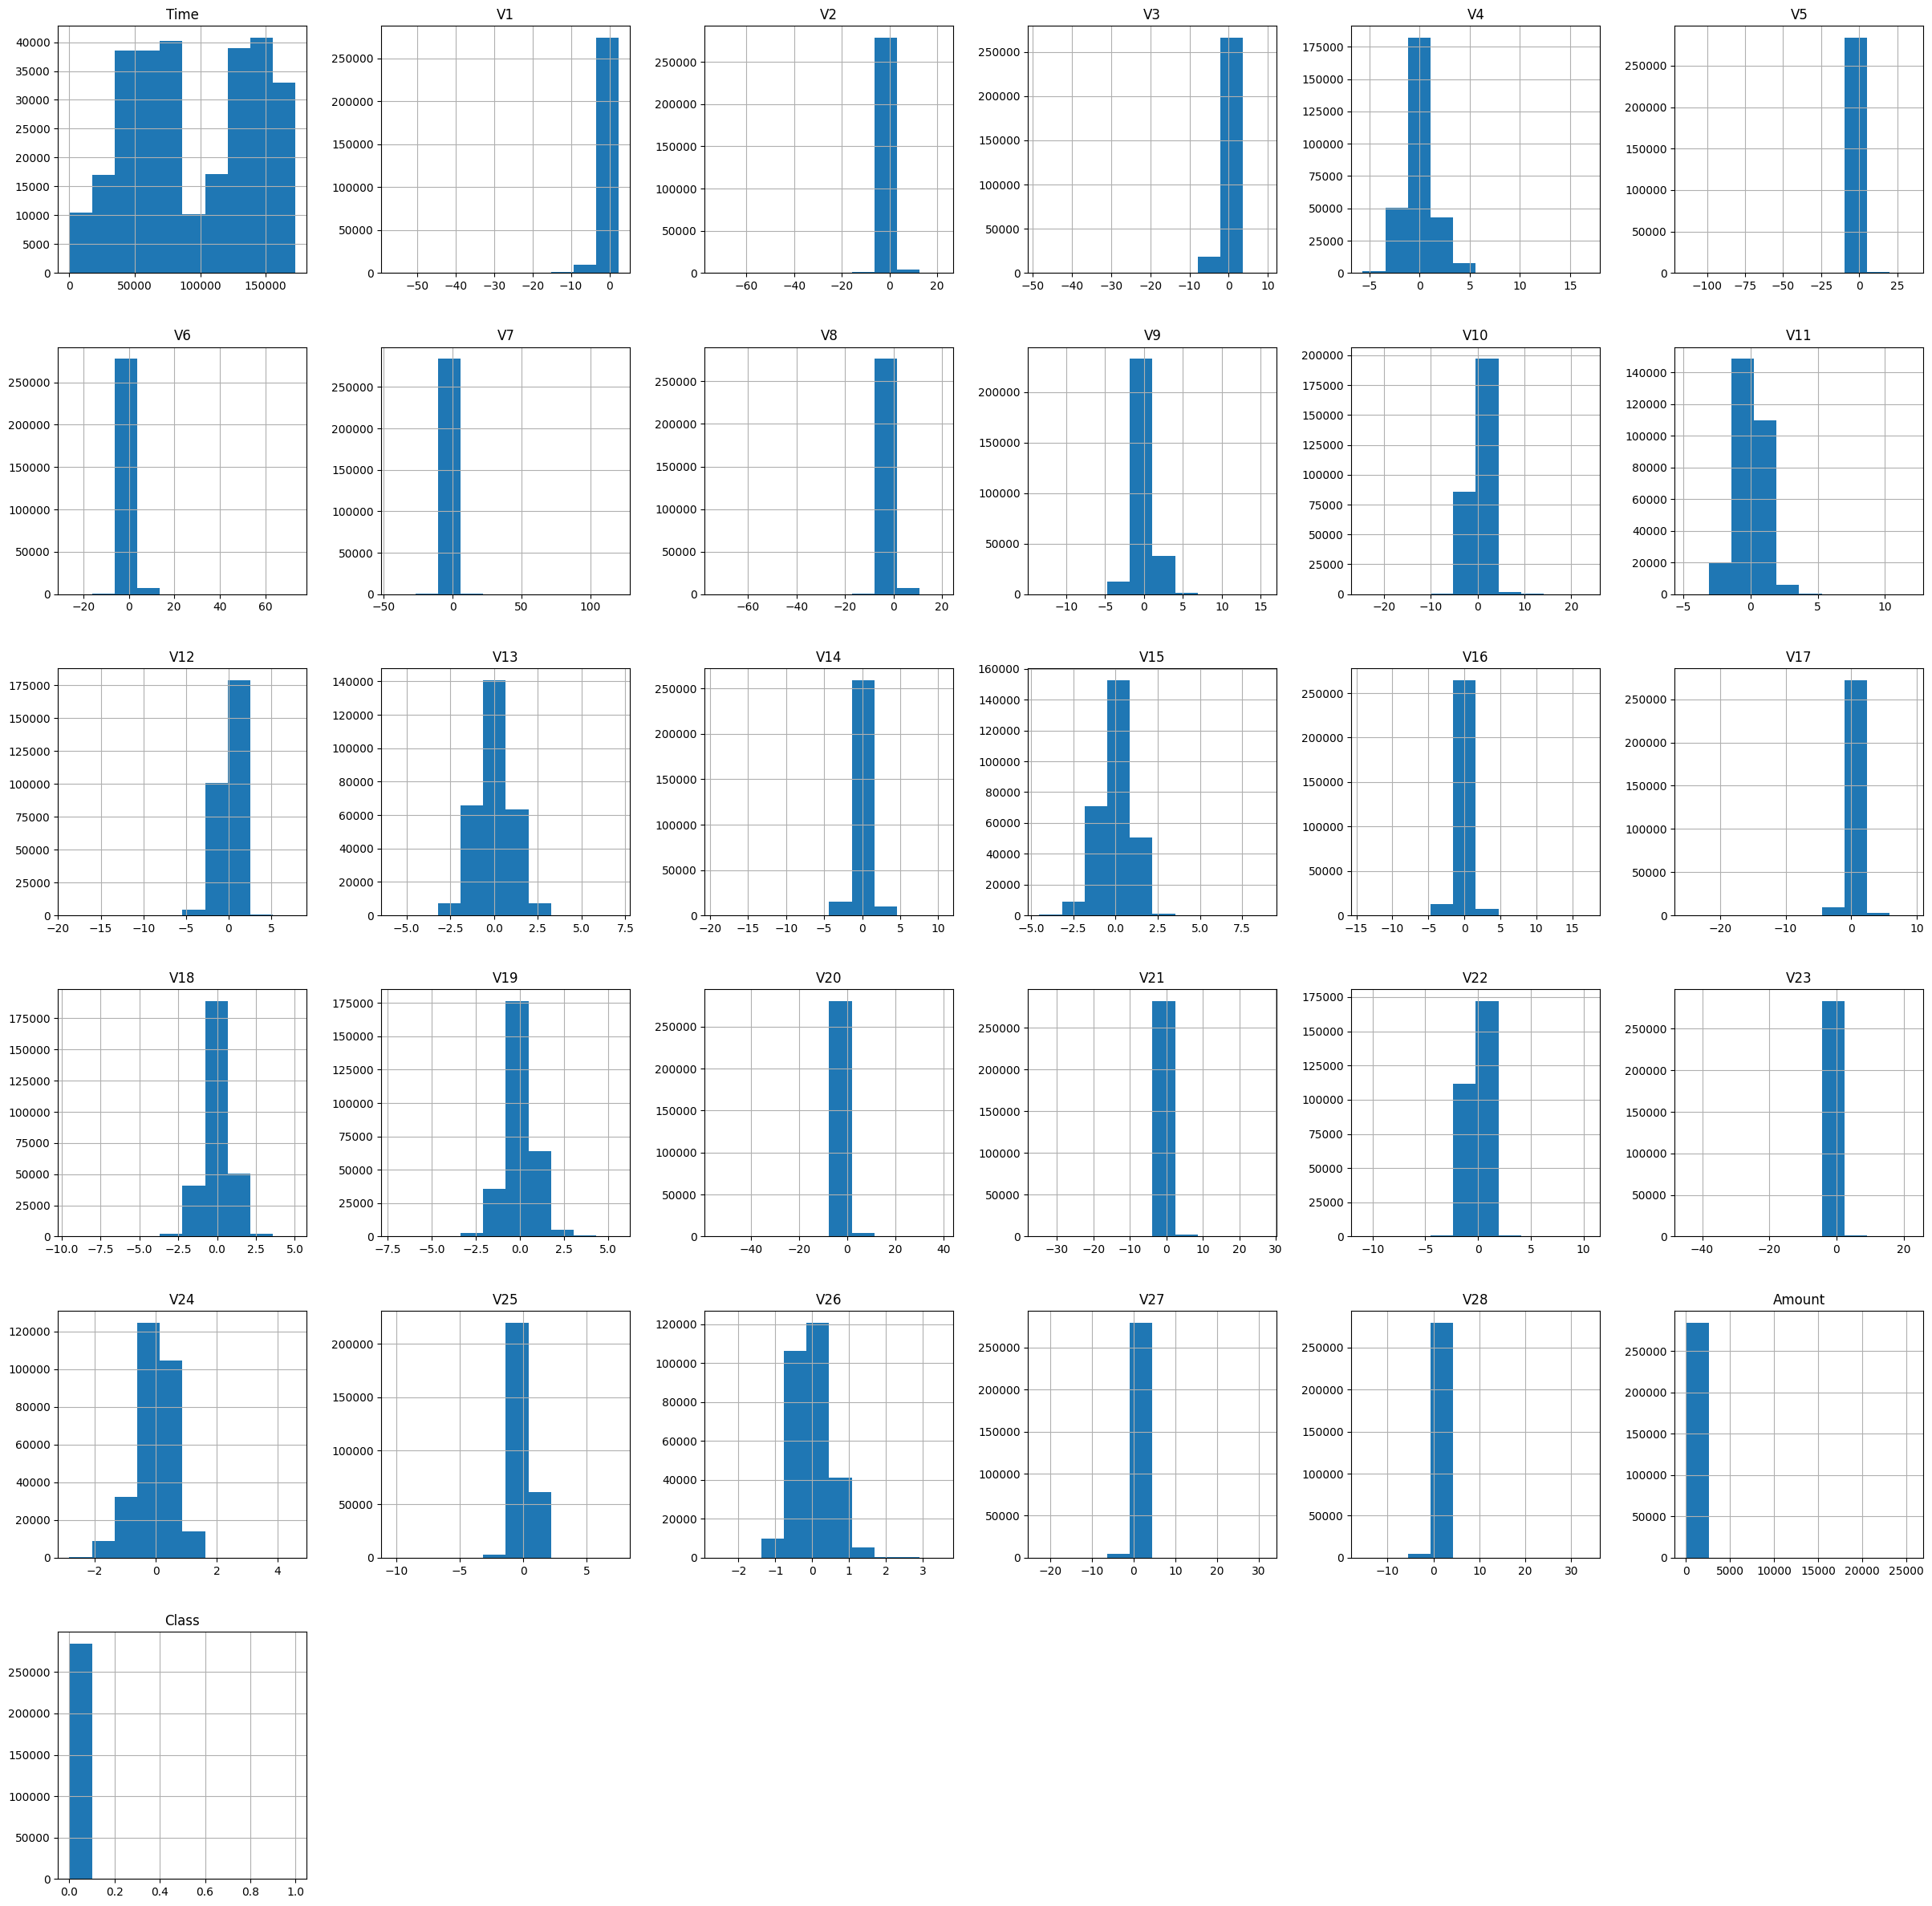

In [22]:
df.hist(figsize=(30,30))

In [23]:
# #pairplots
# df_sample = df.sample(10000)
# sns.pairplot(df_sample)
# plt.show()

## Target Count

In [24]:
y.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

classes are highly imbalanced. There are a lot less fraud transactions compared to non fraud transactions

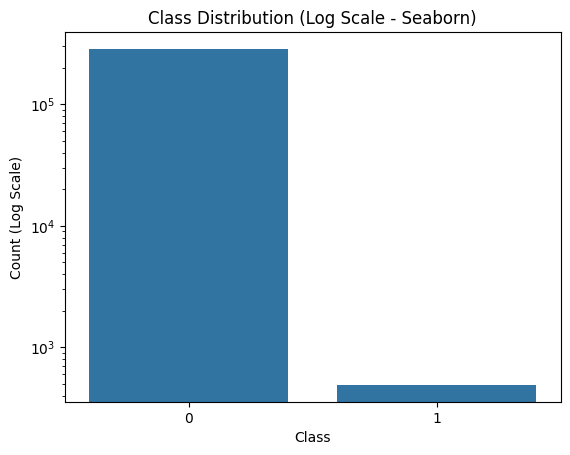

In [25]:
sns.countplot(x=y, data=df)
plt.yscale('log')
plt.title('Class Distribution (Log Scale - Seaborn)')
plt.xlabel('Class')
plt.ylabel('Count (Log Scale)')
plt.show()

# Experiment 1

# Model Training

In [26]:
rng = np.random.RandomState(0) #reproducible tests
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=rng, stratify=y)
#create cross val
cv = StratifiedKFold(n_splits=5)
X_train.shape

(227845, 30)

## Quick Model - Logistic Regression

We will start with a Logistic Regression model because it trains very quickly; we will be able to get a sense of the models's predictions.

In [27]:
lr_pipeline = Pipeline([('scaler', StandardScaler()),
                         ('model', LogisticRegressionCV(cv=cv, random_state=rng, n_jobs=-1))])
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegressionCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                                      n_jobs=-1,
                                      random_state=RandomState(MT19937) at 0x14B56254B40))])

In [28]:
y_pred_lr = lr_pipeline.predict(X_test)

## Logisitic Regression Report

In [29]:
lr_class_report = classification_report(y_test, y_pred_lr)
print(lr_class_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.63      0.73        98

    accuracy                           1.00     56962
   macro avg       0.92      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



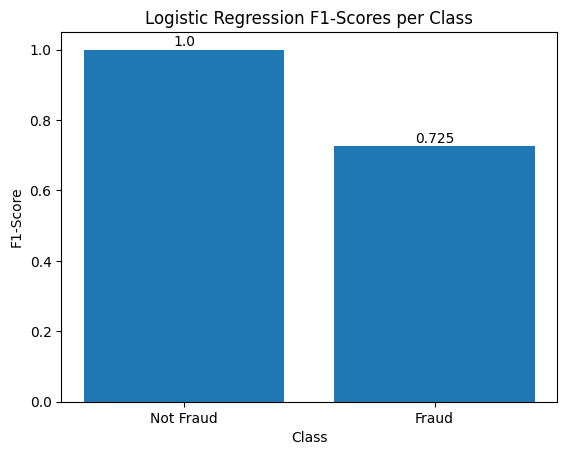

In [30]:
lr_class_report = classification_report(y_test, y_pred_lr, output_dict=True)

f1_scores = {}
for key, value in lr_class_report.items():
    if key.isdigit():
        f1_scores[int(key)] = value['f1-score']  # Convert key to int

# Rename the classes
class_names = ['Not Fraud', 'Fraud']  # Assuming 0 is Not Fraud, 1 is Fraud

# Ensure the order is correct
f1_not_fraud = f1_scores.get(0, 0) # get the value or default to 0.
f1_fraud = f1_scores.get(1, 0)

f1_values = [f1_not_fraud, f1_fraud]

plt.bar(class_names, f1_values)
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('Logistic Regression F1-Scores per Class')

# Annotate the bars with their values
for i, j in enumerate(f1_values):
    plt.text(i, j + 0.01, str(round(j, 3)), ha='center') # add value labels.

plt.show()

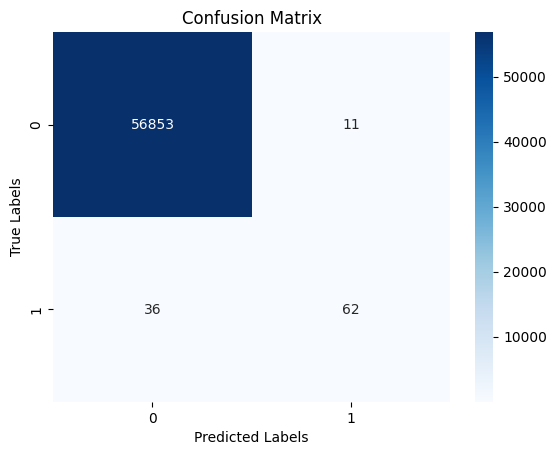

In [31]:
cf_matrix = confusion_matrix(y_test,y_pred_lr)
# Create the heatmap
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')  # fmt='d' for integers

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## Hist Gradient Boosting

In [32]:
#create pipe
hist_pipeline = Pipeline([('scaler', StandardScaler()),
                         ('model', HistGradientBoostingClassifier(n_iter_no_change=10, random_state=rng))])

#params
max_iter = [375, 412, 430]
learning_rate = np.linspace(0.003, 0.007, num=5).tolist()
max_depth = [5, 6, 7]
param_grid = {'model__learning_rate':learning_rate,
               'model__max_iter':max_iter,
               'model__max_depth': max_depth}

hist_grid = GridSearchCV(estimator=hist_pipeline,param_grid=param_grid,cv=cv, scoring='f1', refit=True, n_jobs=-1)
#hist_grid.fit(X_train, y_train) ##(use loaded model in next cell; or uncomment to retrain - retraining will overwrite next line if model "dump" string not changed))
#dump(hist_grid, 'hist_grid_search.pkl')

## Metrics

In [33]:
hist_grid_model = load('models/hist_grid_search.pkl')
# set best estimator to variable
hist_best_model = hist_grid_model.best_estimator_
hist_best_model


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 HistGradientBoostingClassifier(learning_rate=0.007,
                                                max_depth=6, max_iter=430,
                                                random_state=RandomState(MT19937) at 0x14B56255840))])

In [34]:
print(hist_grid_model.best_params_)
print(hist_best_model.named_steps['scaler'].n_features_in_)


{'model__learning_rate': 0.007, 'model__max_depth': 6, 'model__max_iter': 430}
30


In [35]:
hist_grid_model.best_score_

np.float64(0.8573542646745018)

### Class Report

In [36]:
#classification report
hist_y_pred = hist_grid_model.predict(X_test)
hist_report = classification_report(y_test, hist_y_pred)
print('HBG Report','\n',hist_report)

HBG Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.73      0.82        98

    accuracy                           1.00     56962
   macro avg       0.96      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962



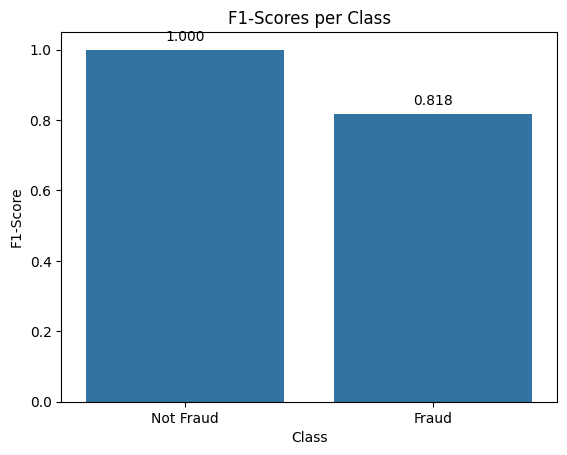

In [37]:
hist_report = classification_report(y_test, hist_y_pred, output_dict=True)



f1_scores = {}
for key, value in hist_report.items():
    if key.isdigit():
        f1_scores[int(key)] = value['f1-score']

class_names = ['Not Fraud', 'Fraud']
f1_not_fraud = f1_scores.get(0, 0)
f1_fraud = f1_scores.get(1, 0)
f1_values = [f1_not_fraud, f1_fraud]

# Create a DataFrame for Seaborn
df = pd.DataFrame({'Class': class_names, 'F1-Score': f1_values})

# Create the bar plot with Seaborn
ax = sns.barplot(x='Class', y='F1-Score', data=df)

# Annotate the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.title('F1-Scores per Class')
plt.show()

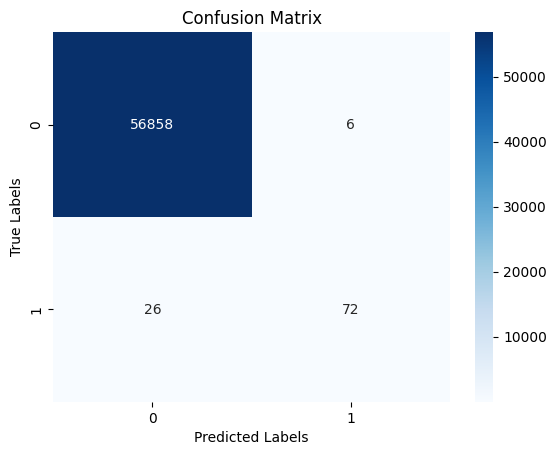

In [38]:
cf_matrix = confusion_matrix(y_test,hist_y_pred)
# Create the heatmap
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')  # fmt='d' for integers

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [41]:
#training predictions
hist_y_pred_train = hist_grid_model.predict(X_train)
hist_train_report = classification_report(y_train, hist_y_pred_train)
print(hist_train_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.99      0.92      0.95       394

    accuracy                           1.00    227845
   macro avg       0.99      0.96      0.98    227845
weighted avg       1.00      1.00      1.00    227845



In [42]:
pd.DataFrame(hist_grid.cv_results_)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

## Retrain Model

I would like to retrain the model because:
- I did not tune different L2 regularization parameters
- I would like to test L2 reg params, because I suspect model may be overfit due to high difference between train pred and test pred
- P.S. grid fit (next cell) is commented out to avoid it (the fit takes 40-60 min) and it did not give significant results 

In [43]:
# hist_l2_pipeline = Pipeline([('scaler', StandardScaler()),
#                          ('model', HistGradientBoostingClassifier(learning_rate=0.007, max_depth=6, max_iter=430,
#                                random_state=rng))])

# param_grid = {'model__l2_regularization': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]}

# grid = GridSearchCV(hist_l2_pipeline, param_grid, cv=cv, scoring='f1', refit=True, n_jobs=-1)
# grid.fit(X_train, y_train)

In [44]:
grid.best_params_

NameError: name 'grid' is not defined

In [ ]:
grid.best_score_

np.float64(0.8570067524517496)

In [ ]:
grid.best_index_

np.int64(0)

### Class Report

In [ ]:
y_pred = grid.predict(X_test)
l2_class_report = classification_report(y_test, y_pred)
print(l2_class_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.73      0.82        98

    accuracy                           1.00     56962
   macro avg       0.96      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962



## Combine L2 train with full param grid

only training l2 did not get better results, going to attempt to train with full param grid from the first model training
- P.S. grid fit (next cell) is commented out to avoid it (the fit takes 40-60 min) and it did not give significant results 


In [ ]:
# #create pipe
# hist_pipeline = Pipeline([('scaler', StandardScaler()),
#                          ('model', HistGradientBoostingClassifier(n_iter_no_change=10, random_state=rng))])

# #params
# max_iter = [375, 412, 430]
# learning_rate = np.linspace(0.003, 0.007, num=5).tolist()
# max_depth = [5, 6, 7]
# param_grid = {'model__learning_rate':learning_rate,
#                'model__max_iter':max_iter,
#                'model__max_depth': max_depth,
#                'model__l2_regularization': [0.01,0.03,0.05,0.07,]}

# grid = GridSearchCV(estimator=hist_pipeline,param_grid=param_grid,cv=cv, scoring='f1', refit=True, n_jobs=-1)
# grid.fit(X_train, y_train)

KeyboardInterrupt: 

### Class Report

In [ ]:
y_pred = grid.predict(X_test)
l2_class_report = classification_report(y_test, y_pred)
print(l2_class_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.74      0.83        98

    accuracy                           1.00     56962
   macro avg       0.97      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962



# Model Training 2

We are getting precision score  0.97, recall score 0.87, and f1 score 0.91.  In the first model training set, I did not do anyhing feature elimination. The data was given to us already after principal component analysis was performed, so all the data was pretty much balanced and without multicolinearity (assumed). I will now run feature selection to see if we can improve the models

## EDA

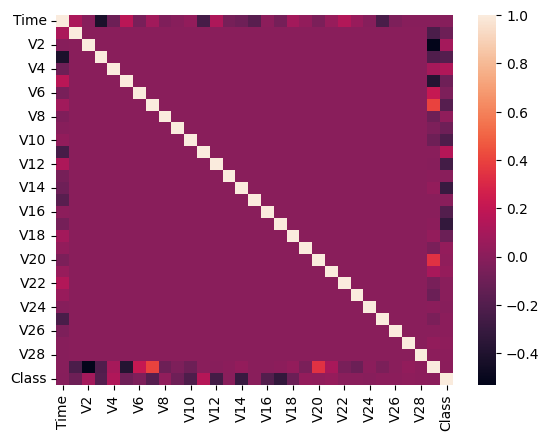

In [ ]:
# correlation matrix
corr_matrix = df.corr()
sns.heatmap(corr_matrix)
plt.show()

like we assumed, there are no issues with multicolinearity

In [ ]:
#mutual information between each feature and target
mutual_info = mutual_info_classif(X_train,y_train)

In [ ]:
mutual_info

array([0.00039513, 0.00040747, 0.00047372, 0.0004787 , 0.00052559,
       0.00062599, 0.00084037, 0.00130617, 0.00144603, 0.00162394,
       0.00173975, 0.00196051, 0.00199628, 0.00201461, 0.00238942,
       0.00245028, 0.00253734, 0.00264444, 0.00337478, 0.00401439,
       0.00429407, 0.00433221, 0.00493802, 0.0050694 , 0.00626036,
       0.00683126, 0.0077444 , 0.00776163, 0.00821687, 0.00836344])

# Experiment 2 - With RFECV

## Model Training

We are using the same pipeline as in the first model training, but we are introducing recursive feature elimination with Logistic Regression to find the best set of features, before training on the hyperparameters

In [ ]:
# #create pipe
# hist_pipeline = Pipeline([('scaler', StandardScaler()),
#                           ('reduce_dim', RFECV(LogisticRegression(n_jobs=-1,random_state=rng), cv=cv, scoring='f1',n_jobs=-1)),
#                          ('model', HistGradientBoostingClassifier(n_iter_no_change=10, random_state=rng))])

# #params
# max_iter = [375, 412, 430]
# learning_rate = np.linspace(0.003, 0.007, num=5).tolist()
# max_depth = [5, 6, 7]
# param_grid = {'model__learning_rate':learning_rate,
#                'model__max_iter':max_iter,
#                'model__max_depth': max_depth}

# hist_rfe_grid = GridSearchCV(estimator=hist_pipeline,param_grid=param_grid,cv=cv, scoring='f1', refit=True, n_jobs=-1)
# # hist_rfe_grid.fit(X_train, y_train) (use loaded model in next cell; or uncomment to retrain - retraining will overwrite next line if model "dump" string not changed)
# dump(hist_rfe_grid, 'hist_rfe_grid_search.pkl')

['hist_rfe_grid_search.pkl']

## Hist RFECV Class Report


In [ ]:
hist_rfe_grid = load('hist_rfe_grid_search.pkl')
y_pred_hist_rfe_grid = hist_rfe_grid.predict(X_test)
hist_rfe_class_report = classification_report(y_test,y_pred_hist_rfe_grid)
print(hist_rfe_class_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.71      0.82        98

    accuracy                           1.00     56962
   macro avg       0.98      0.86      0.91     56962
weighted avg       1.00      1.00      1.00     56962



# Final Conclusion

The best score obtained was with the estimator HistGradientBoosting

In [ ]:
print('Best parameters: \n', hist_grid_model.best_params_, '\n')
print('Best Score: \n', hist_grid_model.best_score_, '\n')

#classification report
hist_y_pred = hist_grid_model.predict(X_test)
hist_report = classification_report(y_test, hist_y_pred)
print('HBG Classification Report','\n',hist_report)

Best parameters: 
 {'model__learning_rate': 0.007, 'model__max_depth': 6, 'model__max_iter': 430} 

Best Score: 
 0.8573542646745018 

HBG Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.73      0.82        98

    accuracy                           1.00     56962
   macro avg       0.96      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962

